In [ ]:
!pip install captcha numpy matplotlib pydot tqdm
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase 
print(characters)

width, height, n_len, n_class = 70, 23, 4, len(characters) + 1

     |████████████████████████████████| 102kB 5.3MB/s 
0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 防止 tensorflow 占用所有显存

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.compat.v1.keras.backend as K

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

Instructions for updating:
non-resource variables are not supported in the long term


# 定义 CTC Loss

In [ ]:
import tensorflow.compat.v1.keras.backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = tf.Print(y_pred, [y_pred], "y_pred")
    labels = tf.Print(labels, [labels], "labels")
    input_length = tf.Print(input_length, [input_length], "input_length")
    label_length = tf.Print(label_length, [label_length], "label_length")
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# 定义网络结构

In [ ]:
from tensorflow.compat.v1.keras.models import *
from tensorflow.compat.v1.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2 if i < 2 else (2, 1))(x)
x = Permute((2, 1, 3))(x)
x = TimeDistributed(Flatten())(x)

rnn_size = 128
x = Bidirectional(RNN(LSTMCell(rnn_size), return_sequences=True))(x)
x = Bidirectional(RNN(LSTMCell(rnn_size), return_sequences=True))(x)
x = Dense(n_class, activation='softmax')(x)

base_model = Model(inputs=input_tensor, outputs=x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
print_node = tf.Print(x, [x], "shape of output")
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([print_node, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=loss_out)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



# 网络结构可视化

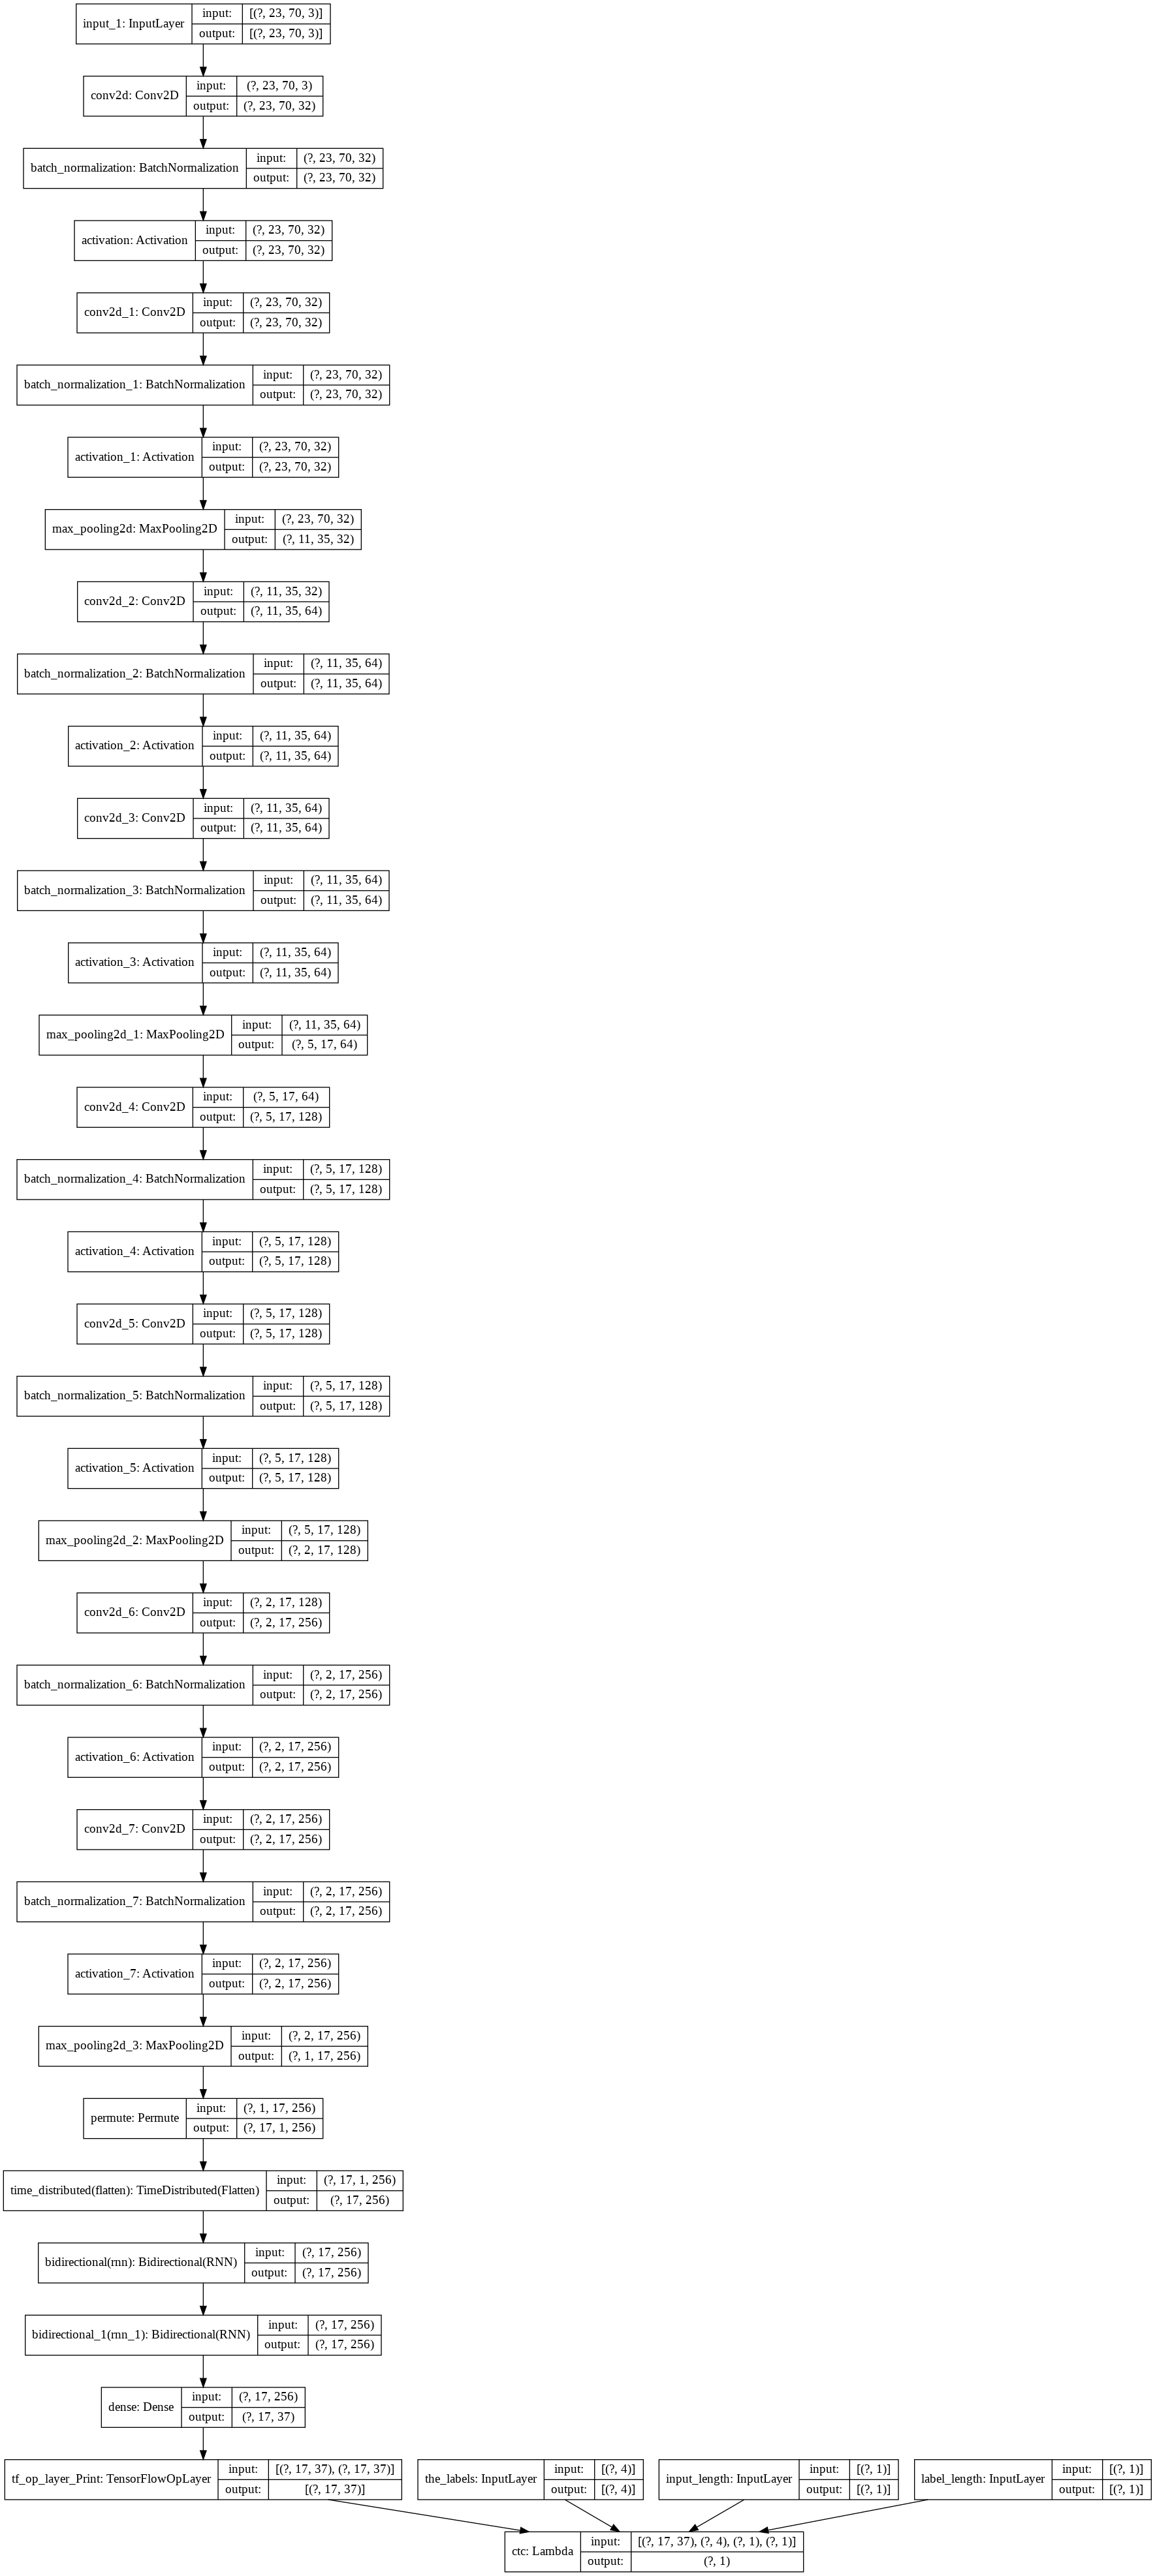

In [ ]:
from tensorflow.compat.v1.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='ctc.png', show_shapes=True)
Image('ctc.png')

In [ ]:
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23, 70, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 70, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 70, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 23, 70, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 70, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 70, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 23, 70, 32)        0     

In [ ]:
from PIL import Image

# 定义数据生成器

In [ ]:
from tensorflow.compat.v1.keras.utils import Sequence
import pickle
import matplotlib.image as mpimg
import math


class CaptchaSequence(Sequence):

  def __init__(self, batch_size, characters, path="/content/drive/My Drive/img_data/", starting_index = 0, n_len=4, width=70, height=23, 
                 input_length=17, label_length=4, last_index = 999):
    self.batch_size = batch_size
    self.path = path
    self.starting_index = starting_index
    self.characters = characters
    self.n_len = n_len
    self.width = width
    self.height = height
    self.input_length = input_length
    self.label_length = label_length
    self.last_index = last_index
    with open(self.path+ "label.txt", 'rb') as handle:
      self.label_dict = pickle.load(handle)

  def __len__(self):
    return math.ceil((self.last_index - self.starting_index) / self.batch_size)

  def __getitem__(self, idx):
    X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
    y = np.zeros((self.batch_size, self.n_len), dtype=np.uint8)
    input_length = np.ones(self.batch_size)*self.input_length
    label_length = np.ones(self.batch_size)*self.label_length
    batch_x_index = [i for i in range(self.starting_index + idx * self.batch_size, self.starting_index + (idx + 1) * self.batch_size)]
    for i, x_i in enumerate(batch_x_index):
      X[i] = mpimg.imread(self.path + '{}.jpg'.format(str(x_i))) / 255
      y[i] = [self.characters.find(x) for x in self.label_dict[x_i].upper()]

    return [X, y, input_length, label_length], np.ones(self.batch_size)

# 测试生成器

Tensor("input_length:0", shape=(?, 1), dtype=int64) Tensor("label_length:0", shape=(?, 1), dtype=int64)
[28 16  5  9]


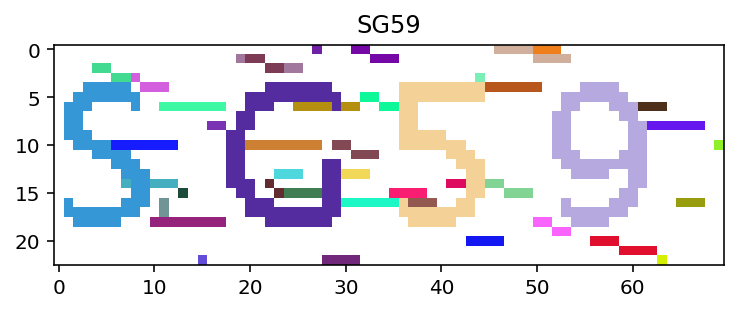

In [ ]:
data = CaptchaSequence(batch_size=1, characters =characters )
[X_test, y_test, _, _], _  = data[0]
plt.imshow(X_test[0])
plt.title(''.join([characters[x] for x in y_test[0]]))
print(input_length, label_length)
print(y_test[0])

In [ ]:
X_test[0].shape

(23, 70, 3)

# 准确率回调函数

In [ ]:
from tqdm import tqdm

def evaluate(model, batch_size=20, starting_index=800):
    batch_acc = 0
    valid_data = CaptchaSequence(batch_size, characters = characters, starting_index=800)
    for [X_test, y_test, _, _], _ in valid_data:
        y_pred = base_model.predict(X_test)
        shape = y_pred.shape
        out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
        if out.shape[1] == 4:
            batch_acc += (y_test == out).all(axis=1).mean()
    return batch_acc / batch_size

In [ ]:
from tensorflow.compat.v1.keras.callbacks import Callback

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = evaluate(base_model)
        logs['val_acc'] = acc
        self.accs.append(acc)
        print(f'\nacc: {acc*100:.4f}')

# 训练模型

In [ ]:
path = '/content/drive/My Drive/CaptchaRecognition/'

In [ ]:
from tensorflow.compat.v1.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.compat.v1.keras.optimizers import *

train_data = CaptchaSequence(characters = characters, batch_size=20, last_index = 799)
valid_data = CaptchaSequence(characters = characters, batch_size=20, starting_index=800, last_index = 999)
callbacks = [EarlyStopping(patience=20), Evaluate(), 
             CSVLogger('ctc.csv'), ModelCheckpoint(path + 'ctc_best.h5', save_best_only=True)]

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-3, amsgrad=True))
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 16.9949WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.

acc: 0.0000
40/40 [==============================] - 100s 3s/step - loss: 16.9949 - val_loss: 15.6725 - val_acc: 0.0000e+00
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 15.3654WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

acc: 0.0000
40/40 [==============================] - 8s 211ms/step - loss: 15.3654 - val_loss: 15.5090 - val_acc: 0.0000e+00
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 15.0579WARNING:tens

Process Keras_worker_ForkPoolWorker-360:
Process Keras_worker_ForkPoolWorker-358:
Process Keras_worker_ForkPoolWorker-359:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Process Keras_worker_ForkPoolWorker-357:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = sel

KeyboardInterrupt: ignored

### 载入最好的模型继续训练一会

In [ ]:
model.load_weights(path + 'ctc_best.h5')

callbacks = [EarlyStopping(patience=20), Evaluate(), 
             CSVLogger('ctc.csv', append=True), ModelCheckpoint(path + 'ctc_best.h5', save_best_only=True)]

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-4, amsgrad=True))
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

# 测试模型

In [ ]:
model.load_weights(path + 'ctc_best.h5')

In [ ]:
import matplotlib.image as mpimg
img=mpimg.imread('0000000.jpg') / 255
img = np.expand_dims(img, axis=0)

[(30, 'U'),
 (4, '4'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (23, 'N'),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (36, ' '),
 (9, '9')]

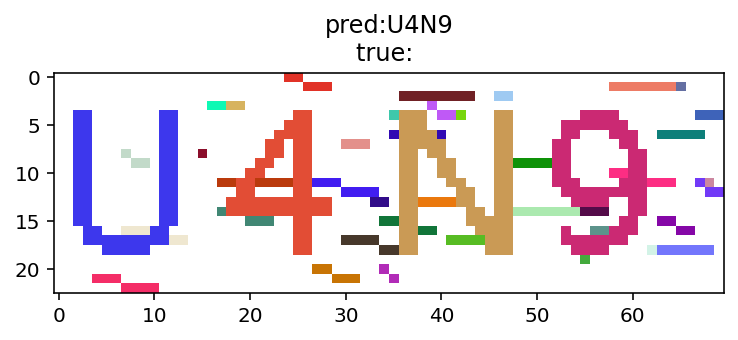

In [ ]:
characters2 = characters + ' '
#[X_test, y_test, _, _], _  = data[0]
#y_pred = base_model.predict(X_test)
y_pred = base_model.predict(img)
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out = ''.join([characters[x] for x in out[0]])
#y_true = ''.join([characters[x] for x in y_test[0]])

#plt.imshow(X_test[0])
plt.imshow(img[0])
plt.title('pred:' + str(out) + '\ntrue: ') #+ str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]
list(zip(argmax, ''.join([characters2[x] for x in argmax])))

In [ ]:
y_pred

# 计算模型总体准确率

In [ ]:
evaluate(base_model)

0.4325

# 保存模型

In [ ]:
base_model.save(path + 'ctc.h5', include_optimizer=False)

# 可视化训练曲线

```sh
pip install pandas
```

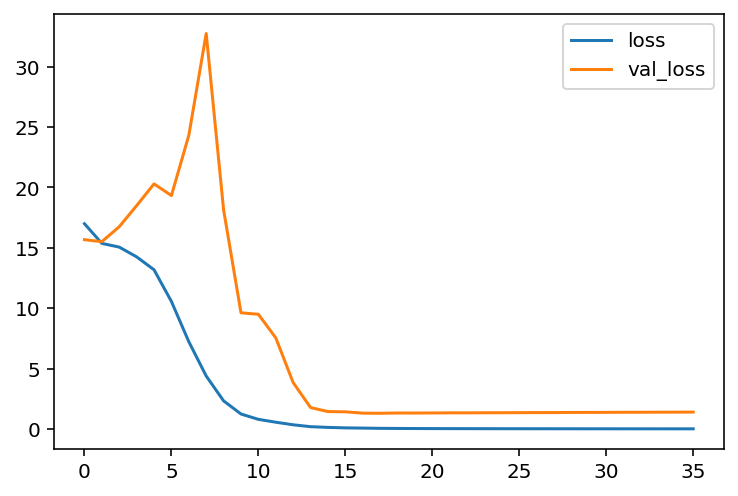

In [ ]:
import pandas as pd

df = pd.read_csv('ctc.csv')
df[['loss', 'val_loss']].plot()

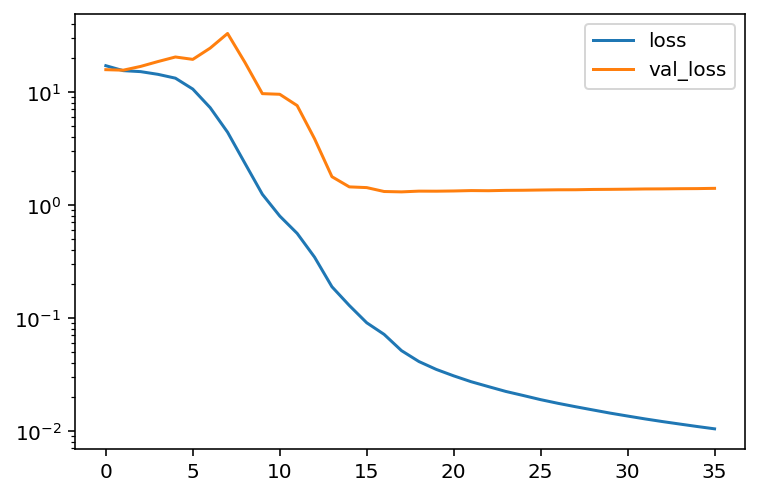

In [ ]:
df[['loss', 'val_loss']].plot(logy=True)

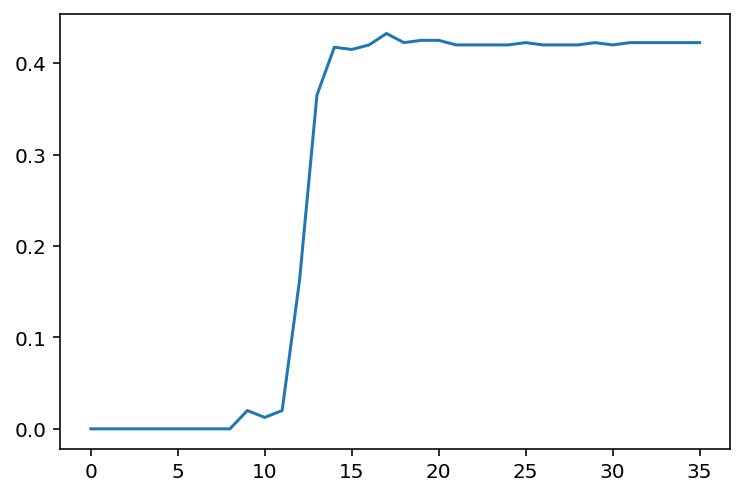

In [ ]:
df['val_acc'].plot()